In [10]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# ─── Load Preprocessed Data ───────────────────────────────────────────────────
df = pd.read_csv(
    'mouse_ALL_BP-ID_logClip_logRdenFC_GOconcat_exploded.tsv',
    sep='\t', header=None,
    names=['gene', 'scoreA', 'scoreB', 'goslim']
)

# ─── Group by GO term ─────────────────────────────────────────────────────────
grouped = (
    df.groupby('goslim')
      .agg(
         gene_count=('gene', 'nunique'),
         scoreA_mean=('scoreA', 'mean'),
         scoreB_mean=('scoreB', 'mean')
      )
      .reset_index()
)

# ─── Mann–Whitney U test (scoreB in vs out per GO term) ───────────────────────
gene_to_scoreB = df.set_index('gene')['scoreB'].to_dict()
all_genes = set(gene_to_scoreB)

pvals = []
for term in grouped['goslim']:
    genes_in = set(df[df['goslim'] == term]['gene'])
    genes_out = all_genes - genes_in

    s_in = [gene_to_scoreB[g] for g in genes_in if g in gene_to_scoreB]
    s_out = [gene_to_scoreB[g] for g in genes_out if g in gene_to_scoreB]

    if len(s_in) >= 3 and len(s_out) >= 3:
        _, p = mannwhitneyu(s_in, s_out, alternative='two-sided')
    else:
        p = np.nan
    pvals.append(p)

grouped['pB']   = pvals
grouped['fdrB'] = multipletests(grouped['pB'].fillna(1), method='fdr_bh')[1]
grouped['sigB'] = -np.log10(grouped['fdrB'].replace(0, np.nan))

# ─── Filter for Significance ──────────────────────────────────────────────────
# grouped_sig = grouped[grouped['fdrB'] < 0.05].copy()


In [14]:
pvals = []
excluded_terms = []  # store terms excluded due to small group size

for term in grouped['goslim']:
    genes_in = set(df[df['goslim'] == term]['gene'])
    genes_out = all_genes - genes_in

    s_in = [gene_to_scoreB[g] for g in genes_in if g in gene_to_scoreB]
    s_out = [gene_to_scoreB[g] for g in genes_out if g in gene_to_scoreB]

    if len(s_in) >= 3 and len(s_out) >= 3:
        _, p = mannwhitneyu(s_in, s_out, alternative='two-sided')
    else:
        p = np.nan
        excluded_terms.append(term)

    pvals.append(p)

# Add p-values to dataframe
grouped['pB'] = pvals
grouped['fdrB'] = multipletests(grouped['pB'].fillna(1), method='fdr_bh')[1]
grouped['sigB'] = -np.log10(grouped['fdrB'].replace(0, np.nan))

# Count how many were excluded
print(f"Number of GO terms excluded from test due to small group size: {len(excluded_terms)}")
print(f"Total GO terms: {len(grouped)}")
print(f"Fraction excluded: {len(excluded_terms) / len(grouped):.2%}")


Number of GO terms excluded from test due to small group size: 0
Total GO terms: 14
Fraction excluded: 0.00%


In [7]:
# Build the annotation table as a dictionary (from your input)
go_annotations = [
    ("GO:0002376", "Immune system process", "Biological Process", "Processes involved in the development or functioning of the immune system."),
    ("GO:0006351", "Transcription, DNA-templated", "Biological Process", "The synthesis of RNA from a DNA template."),
    ("GO:0006629", "Lipid metabolic process", "Biological Process", "Chemical reactions and pathways involving lipids."),
    ("GO:0008283", "Cell population proliferation", "Biological Process", "Increase in cell number through cell division."),
    ("GO:0012501", "Programmed cell death", "Biological Process", "Cell death mediated by an intracellular program (e.g., apoptosis)."),
    ("GO:0016043", "Cellular component organization", "Biological Process", "Assembly or disassembly of structures within a cell."),
    ("GO:0019538", "Protein metabolic process", "Biological Process", "Chemical reactions and pathways involving proteins."),
    ("GO:0023052", "Signaling", "Biological Process", "The transmission of molecular signals within and between cells."),
    ("GO:0030154", "Cell differentiation", "Biological Process", "Process by which a less specialized cell becomes more specialized."),
    ("GO:0042592", "Homeostatic process", "Biological Process", "Any process involved in maintaining an internal steady state."),
    ("GO:0048731", "System development", "Biological Process", "The progression of an organ system over time, from formation to maturity."),
    ("GO:0050896", "Response to stimulus", "Biological Process", "A change in cell or organism activity as a result of a stimulus."),
    ("GO:0051234", "Establishment of localization", "Biological Process", "Transport or maintenance of a substance in a specific location."),
    ("GO:1901135", "Carbohydrate derivative metabolic process", "Biological Process", "Reactions involving carbohydrate derivatives.")
]

go_df = pd.DataFrame(go_annotations, columns=['goslim', 'go_name', 'category', 'description'])


In [15]:
go_df = pd.DataFrame(go_annotations, columns=['goslim', 'go_name', 'category', 'description'])
plot_df = grouped_sig.merge(go_df, on='goslim', how='left')
plot_df['go_name'] = plot_df['go_name'].fillna('Unknown term')
plot_df['description'] = plot_df['description'].fillna('N/A')
plot_df['category'] = plot_df['category'].fillna('N/A')

# ─── Plot with Plotly ─────────────────────────────────────────────────────────
fig = px.scatter(
    plot_df,
    x='scoreA_mean',
    y='scoreB_mean',
    size='gene_count',
    color='sigB',
    color_continuous_scale='YlOrBr',
    hover_data={
        'goslim': True,
        'go_name': True,
        'category': True,
        'description': True,
        'gene_count': True,
        'scoreA_mean': ':.2f',
        'scoreB_mean': ':.2f',
        'sigB': ':.2f'
    },
    labels={
        'scoreA_mean': 'Mean log₂(Clip Enrichment)',
        'scoreB_mean': 'Mean log₂(Ribosome Density Fold Change)',
        'sigB': '-log₁₀(FDR)'
    },
    title='GO Term Enrichment on Ribosome Density Changes (FDR < 0.05)'
)

fig.update_traces(marker=dict(line=dict(color='black', width=1)))
fig.update_layout(
    template='plotly_white',
    width=1000,
    height=700,
    xaxis=dict(dtick=0.25, zeroline=True, zerolinecolor='gray'),
    yaxis=dict(dtick=0.25, zeroline=True, zerolinecolor='gray'),
    coloraxis_colorbar=dict(title='–log₁₀(FDR)')
)

fig.show()

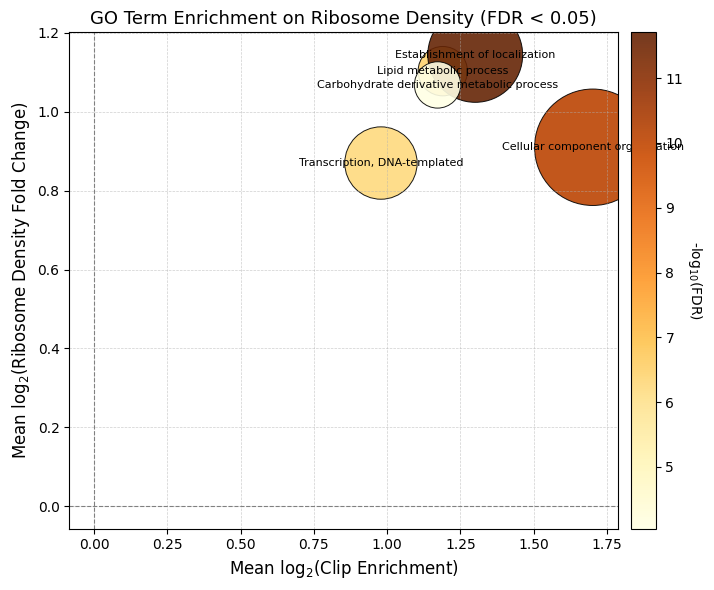

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# ─── Prepare Plotting Data ────────────────────────────────────────────────────
x = plot_df['scoreA_mean']
y = plot_df['scoreB_mean']
size = plot_df['gene_count'] * 3  # scaling for visibility
color = plot_df['sigB']

# Normalize color scale for consistent coloring
norm = mcolors.Normalize(vmin=color.min(), vmax=color.max())
cmap = cm.YlOrBr

# ─── Create Figure ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7.5, 6))

scatter = ax.scatter(
    x, y,
    s=size,
    c=color,
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=0.7,
    alpha=0.9
)

# ─── Grid, Reference Lines, Aesthetics ────────────────────────────────────────
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.8)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# ─── Axis Labeling ────────────────────────────────────────────────────────────
ax.set_xlabel('Mean log$_2$(Clip Enrichment)', fontsize=12)
ax.set_ylabel('Mean log$_2$(Ribosome Density Fold Change)', fontsize=12)
ax.set_title('GO Term Enrichment on Ribosome Density (FDR < 0.05)', fontsize=13)

# ─── Colorbar ─────────────────────────────────────────────────────────────────
cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('-log$_{10}$(FDR)', rotation=270, labelpad=15)

# ─── Optional: Annotate Top Terms (up to N) ───────────────────────────────────
top_n = plot_df.sort_values('sigB', ascending=False).head(10)
for _, r in top_n.iterrows():
    ax.text(
        r['scoreA_mean'], r['scoreB_mean'],
        r['go_name'],
        fontsize=8,
        ha='center',
        va='center',
        color='black'
    )

# ─── Save Figure ──────────────────────────────────────────────────────────────
plt.tight_layout()
plt.savefig('go_enrichment_ribodensity.pdf')  # for print
plt.savefig('go_enrichment_ribodensity.svg')  # for vector editing
plt.show()


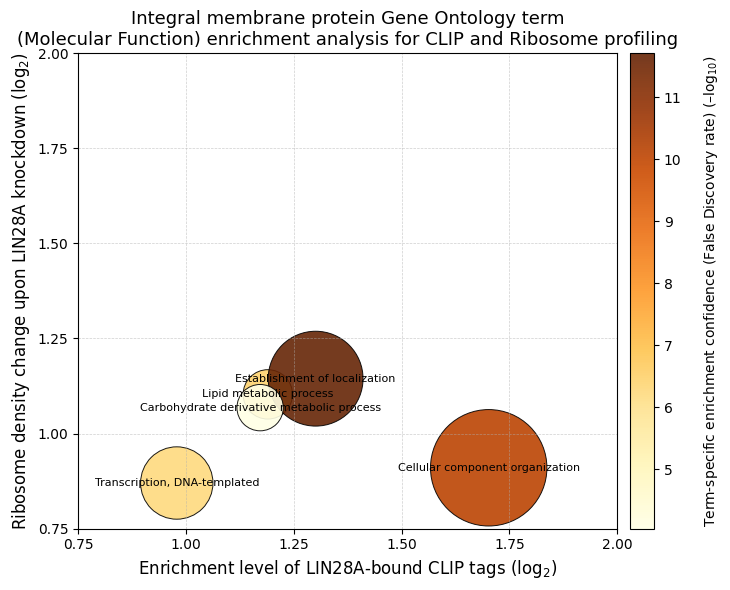

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# ─── Prepare Data ─────────────────────────────────────────────────────────────
x = plot_df['scoreA_mean']
y = plot_df['scoreB_mean']
size = plot_df['gene_count'] * 3
color = plot_df['sigB']

norm = mcolors.Normalize(vmin=color.min(), vmax=color.max())
cmap = cm.YlOrBr

# ─── Create Figure ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7.5, 6))

scatter = ax.scatter(
    x, y,
    s=size,
    c=color,
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=0.7,
    alpha=0.9
)

# ─── Set Axis Limits (Zoom In) ────────────────────────────────────────────────
ax.set_xlim(0.75, x.max() + 0.2)
ax.set_ylim(0.75, y.max() + 0.2)

# ─── Add Grid Lines Every 0.25 ────────────────────────────────────────────────
xticks = np.arange(0.75, np.ceil(x.max()) + 0.25, 0.25)
yticks = np.arange(0.75, np.ceil(y.max()) + 0.25, 0.25)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# ─── Zero Lines (optional: these may be outside zoom range) ──────────────────
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# ─── Labels and Title ─────────────────────────────────────────────────────────
ax.set_xlabel('Enrichment level of LIN28A-bound CLIP tags (log$_2$)', fontsize=12)
ax.set_ylabel('Ribosome density change upon LIN28A knockdown (log$_2$)', fontsize=12)
ax.set_title(
    'Integral membrane protein Gene Ontology term\n'
    '(Molecular Function) enrichment analysis for CLIP and Ribosome profiling',
    fontsize=13
)

# ─── Colorbar ─────────────────────────────────────────────────────────────────
cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label(
    'Term-specific enrichment confidence (False Discovery rate) (–log$_{10}$)',
    rotation=90, labelpad=15
)

# ─── Optional: Annotate top GO terms ──────────────────────────────────────────
top_n = plot_df.sort_values('sigB', ascending=False).head(10)
for _, r in top_n.iterrows():
    if r['scoreA_mean'] > 0.75 and r['scoreB_mean'] > 0.75:
        ax.text(
            r['scoreA_mean'], r['scoreB_mean'],
            r['go_name'],
            fontsize=8,
            ha='center',
            va='center',
            color='black'
        )

# ─── Save Figure ──────────────────────────────────────────────────────────────
plt.tight_layout()
plt.savefig('GO_enrichment_LIN28A_CLIP_Ribo_zoomed.pdf')
plt.savefig('GO_enrichment_LIN28A_CLIP_Ribo_zoomed.svg')
plt.show()


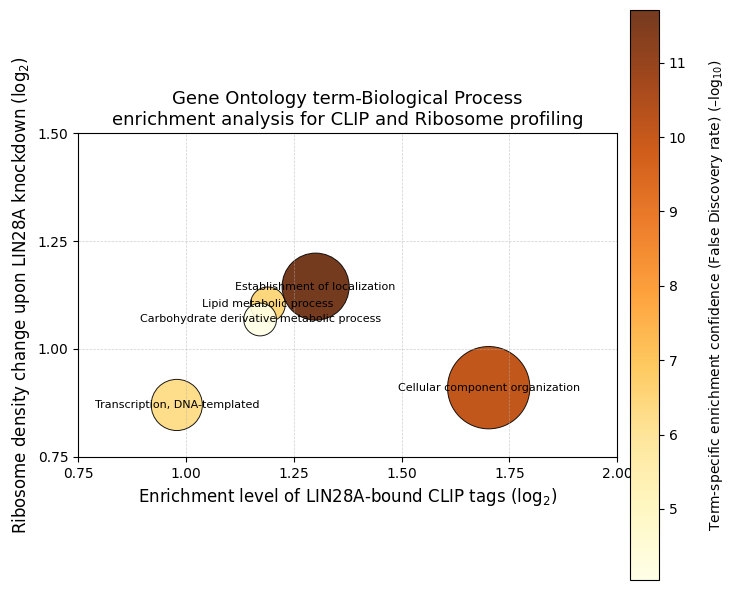

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# ─── Prepare Data ─────────────────────────────────────────────────────────────
x = plot_df['scoreA_mean']
y = plot_df['scoreB_mean']
size = plot_df['gene_count'] * 1.5
color = plot_df['sigB']

norm = mcolors.Normalize(vmin=color.min(), vmax=color.max())
cmap = cm.YlOrBr

# ─── Create Figure ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7.5, 6))

scatter = ax.scatter(
    x, y,
    s=size,
    c=color,
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=0.7,
    alpha=0.9
)

# ─── Axis Limits and Ticks ────────────────────────────────────────────────────
ax.set_xlim(0.75, 2.00)
ax.set_ylim(0.75, 1.50)

ax.set_xticks(np.arange(0.75, 2.01, 0.25))
ax.set_yticks(np.arange(0.75, 1.51, 0.25))

# ─── Make Grid Squares ────────────────────────────────────────────────────────
ax.set_aspect('equal', adjustable='box')

# ─── Grid and Reference Lines ─────────────────────────────────────────────────
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# ─── Labels and Title ─────────────────────────────────────────────────────────
ax.set_xlabel('Enrichment level of LIN28A-bound CLIP tags (log$_2$)', fontsize=12)
ax.set_ylabel('Ribosome density change upon LIN28A knockdown (log$_2$)', fontsize=12)
ax.set_title(
    'Gene Ontology term-Biological Process\n'
    'enrichment analysis for CLIP and Ribosome profiling',
    fontsize=13
)

# ─── Colorbar ─────────────────────────────────────────────────────────────────
cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label(
    'Term-specific enrichment confidence (False Discovery rate) (–log$_{10}$)',
    rotation=90, labelpad=15
)

# ─── Annotate top GO terms (if visible in plot range) ─────────────────────────
top_n = plot_df.sort_values('sigB', ascending=False).head(10)
for _, r in top_n.iterrows():
    if 0.75 <= r['scoreA_mean'] <= 2.00 and 0.75 <= r['scoreB_mean'] <= 1.50:
        ax.text(
            r['scoreA_mean'], r['scoreB_mean'],
            r['go_name'],
            fontsize=8,
            ha='center',
            va='center',
            color='black'
        )

# ─── Save Figure ──────────────────────────────────────────────────────────────
plt.tight_layout()
plt.savefig('GO_enrichment_LIN28A_CLIP_Ribo_squaregrid.pdf')
plt.savefig('GO_enrichment_LIN28A_CLIP_Ribo_squaregrid.svg')
plt.show()


In [ ]:
# –log₁₀(FDR) ≥ 1.3

In [ ]:
ax.set_title(
    'Gene Ontology term-Biological Process\n'
    'enrichment analysis for CLIP and Ribosome profiling',
    fontsize=13
)

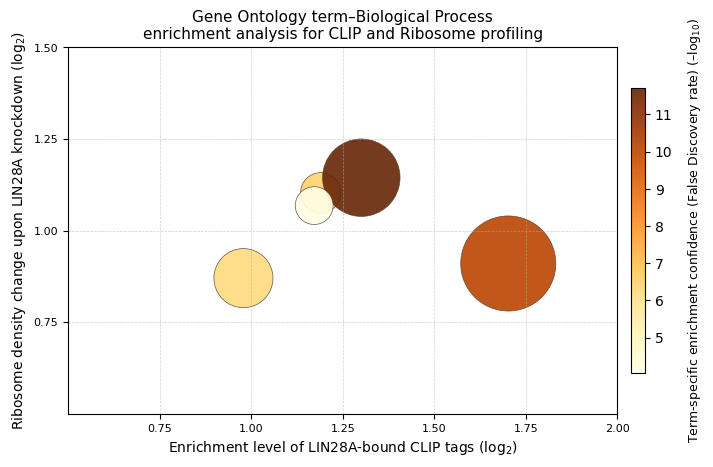

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# ─── Prepare Data ─────────────────────────────────────────────────────────────
x = plot_df['scoreA_mean']
y = plot_df['scoreB_mean']
size = plot_df['gene_count'] * 2
color = plot_df['sigB']

norm = mcolors.Normalize(vmin=color.min(), vmax=color.max())
cmap = cm.YlOrBr

# ─── Create Figure ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7.5, 6))

scatter = ax.scatter(
    x, y,
    s=size,
    c=color,
    cmap=cmap,
    norm=norm,
    edgecolor='#5C4033',
    linewidth=0.5,
    alpha=0.9
)

# ─── Axis Limits and Grid Ticks ───────────────────────────────────────────────
ax.set_xlim(0.5, 2.0)
ax.set_ylim(0.5, 1.5)

ax.set_xticks([0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
ax.set_yticks([0.75, 1.0, 1.25, 1.5])

ax.tick_params(axis='both', labelsize=8)

ax.set_aspect('equal', adjustable='box')

# ─── Grid Lines ───────────────────────────────────────────────────────────────
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# ─── Labels and Title (Reduced Font Size) ─────────────────────────────────────
ax.set_xlabel('Enrichment level of LIN28A-bound CLIP tags (log$_2$)', fontsize=10)
ax.set_ylabel('Ribosome density change upon LIN28A knockdown (log$_2$)', fontsize=10)
ax.set_title(
    'Gene Ontology term–Biological Process\n'
    'enrichment analysis for CLIP and Ribosome profiling',
    fontsize=11
)

# ─── Colorbar (Smaller) ───────────────────────────────────────────────────────
cbar = fig.colorbar(scatter, ax=ax, pad=0.02, shrink=0.5)
cbar.set_label(
    'Term-specific enrichment confidence (False Discovery rate) (–log$_{10}$)',
    rotation=90, labelpad=10, fontsize=9
)

# ─── Omit Bubble Text Annotations ─────────────────────────────────────────────
# (No ax.text())

# ─── Save Figure ──────────────────────────────────────────────────────────────
plt.tight_layout()
plt.savefig('GO_enrichment_LIN28A_cleaned.pdf')
plt.savefig('GO_enrichment_LIN28A_cleaned.svg')
plt.show()


In [ ]:
# captions  for each bubble were addid using FIGMA 
# https://www.figma.com/